In [48]:
import matplotlib.pyplot as plt
import sns
import statsmodels.api as sm
from pyexpat import features
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Wczytywanie danych

In [49]:
file_path = "data.txt"
data = pd.read_csv(file_path, delimiter= "\t")  # Pomijamy opisowe linie
# Wyświetlenie pierwszych wierszy
print(data.head())


   Density  Pct.BF  Age  Weight  Height  Neck  Chest  Abdomen      Waist  \
0   1.0708    12.3   23  154.25   67.75  36.2   93.1     85.2  33.543307   
1   1.0853     6.1   22  173.25   72.25  38.5   93.6     83.0  32.677165   
2   1.0414    25.3   22  154.00   66.25  34.0   95.8     87.9  34.606299   
3   1.0751    10.4   26  184.75   72.25  37.4  101.8     86.4  34.015748   
4   1.0340    28.7   24  184.25   71.25  34.4   97.3    100.0  39.370079   

     Hip  Thigh  Knee  Ankle  Bicep  Forearm  Wrist  
0   94.5   59.0  37.3   21.9   32.0     27.4   17.1  
1   98.7   58.7  37.3   23.4   30.5     28.9   18.2  
2   99.2   59.6  38.9   24.0   28.8     25.2   16.6  
3  101.2   60.1  37.3   22.8   32.4     29.4   18.2  
4  101.9   63.2  42.2   24.0   32.2     27.7   17.7  


# Wyświetlenie wszystkich wykresów punktowych oddzielnie

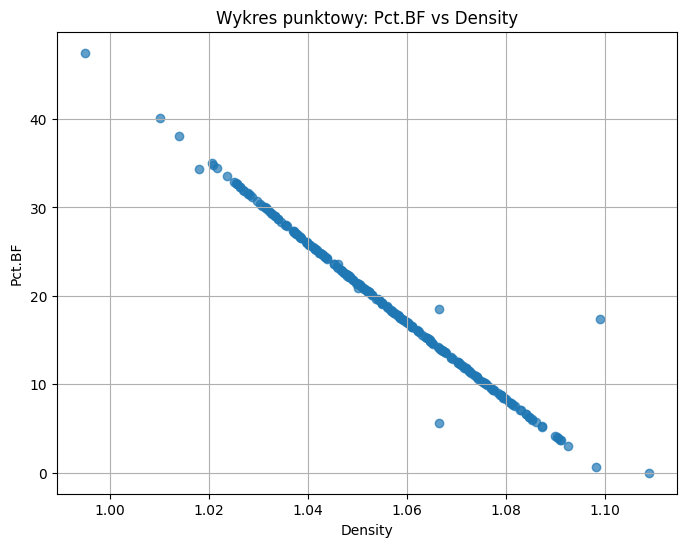

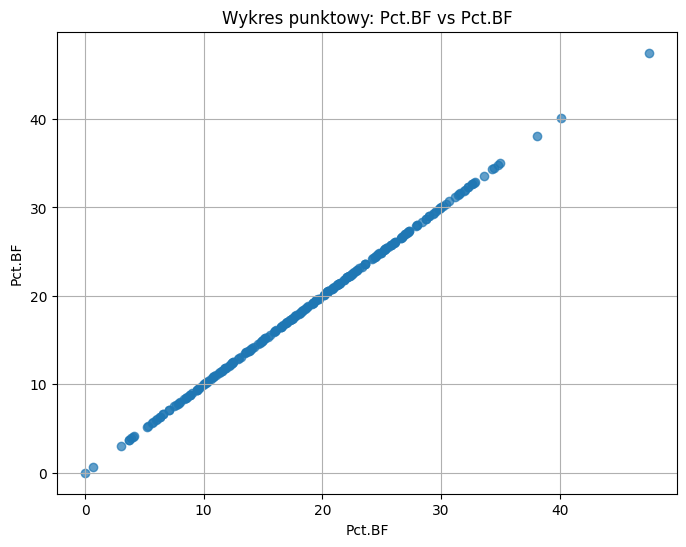

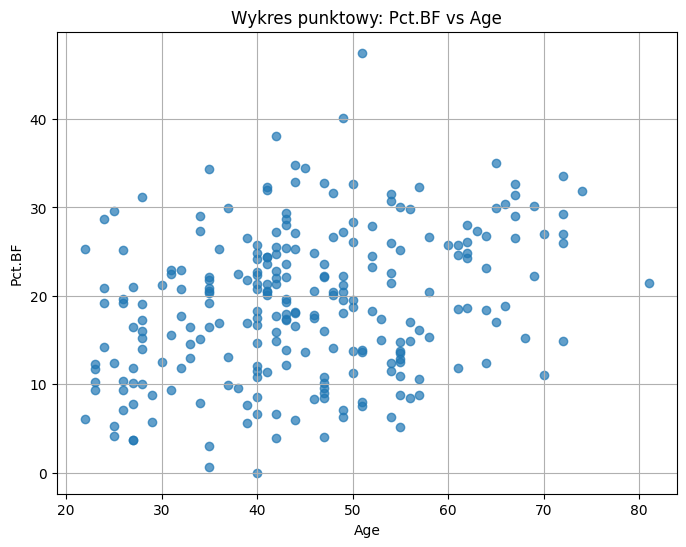

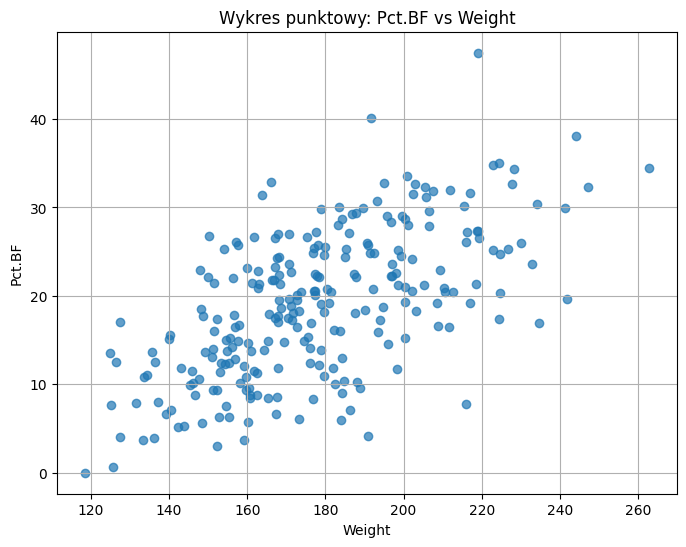

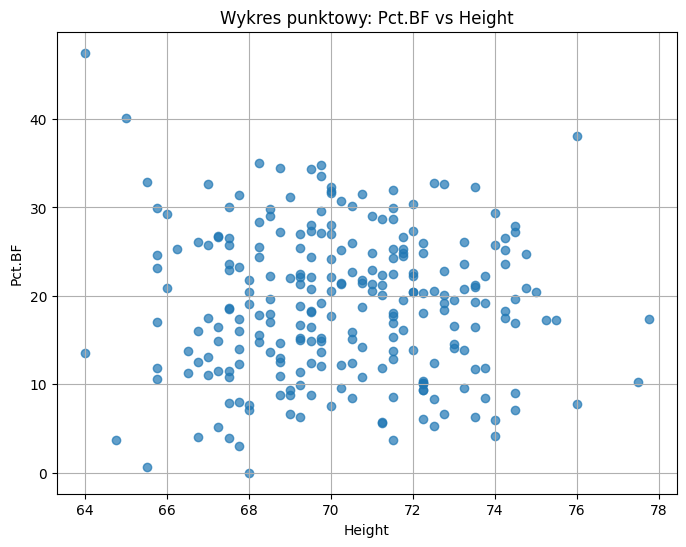

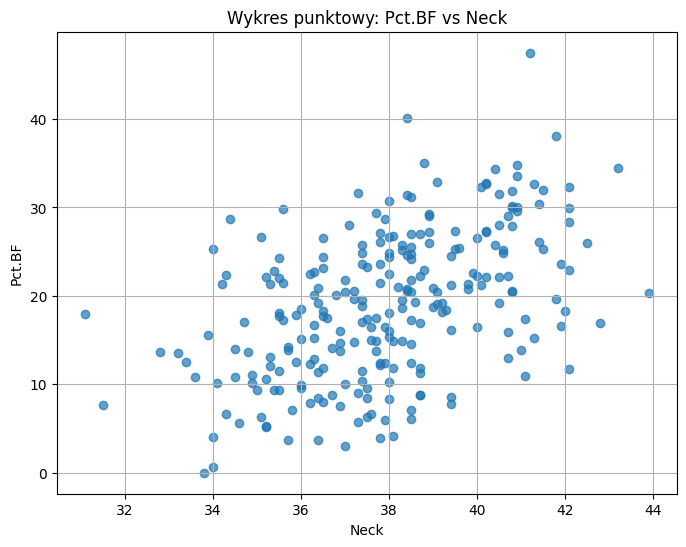

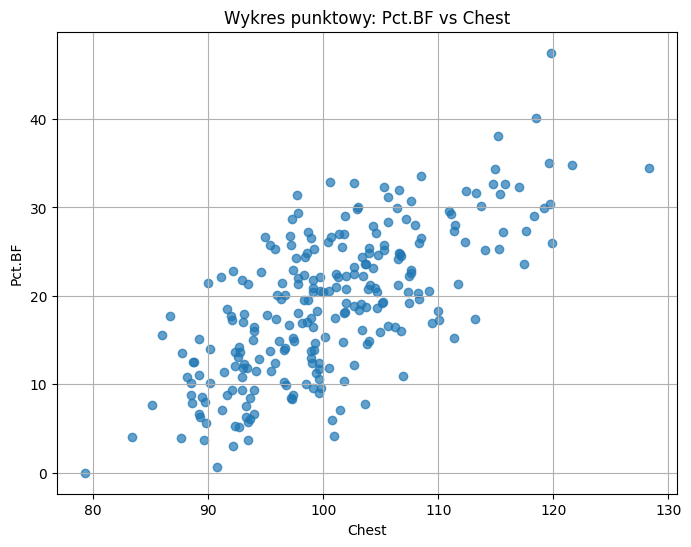

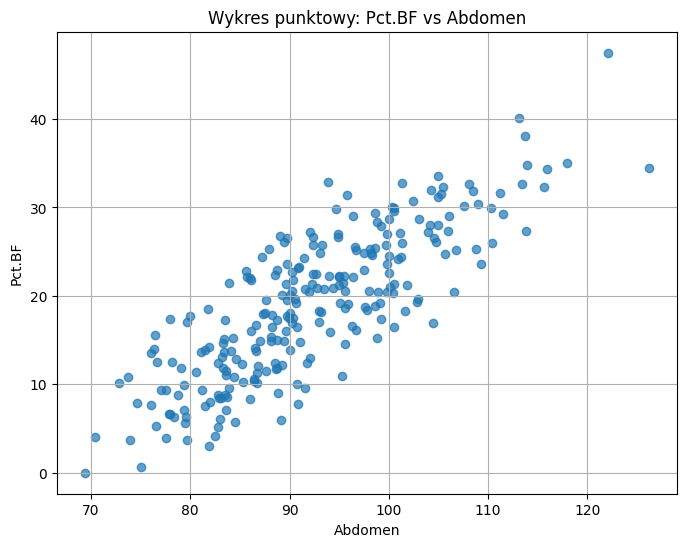

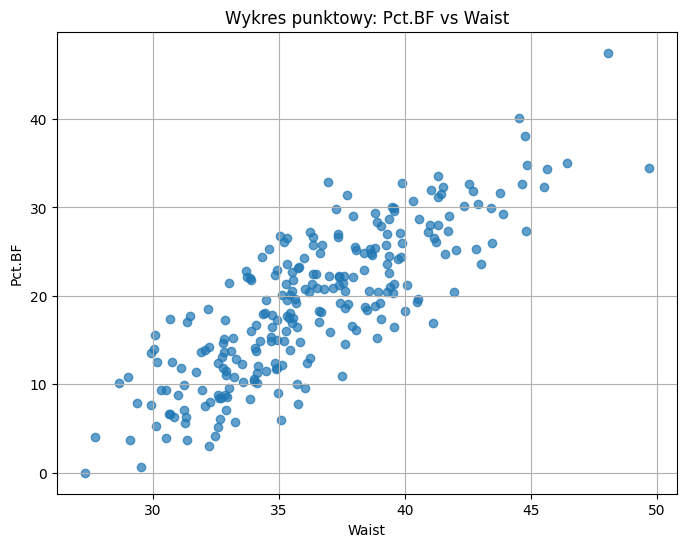

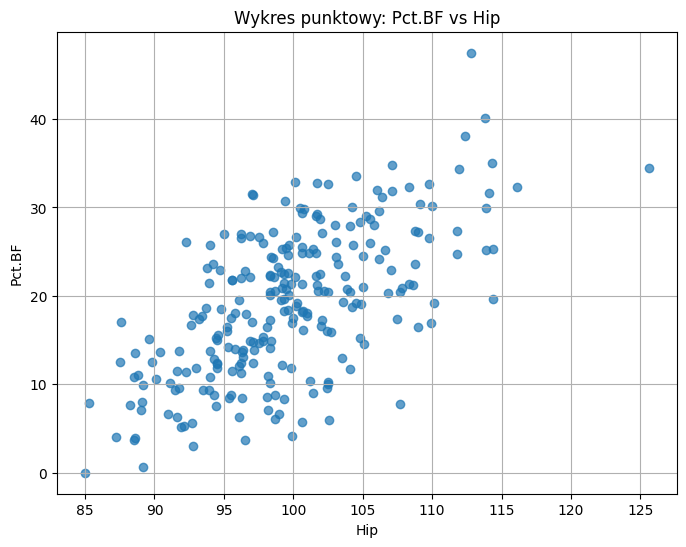

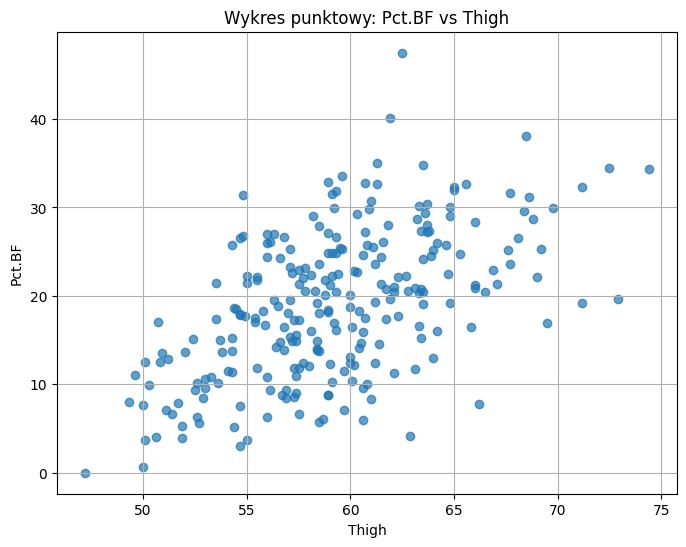

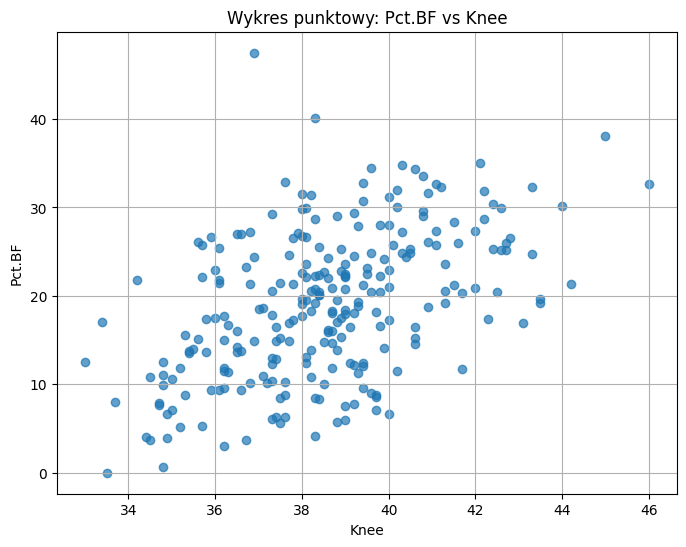

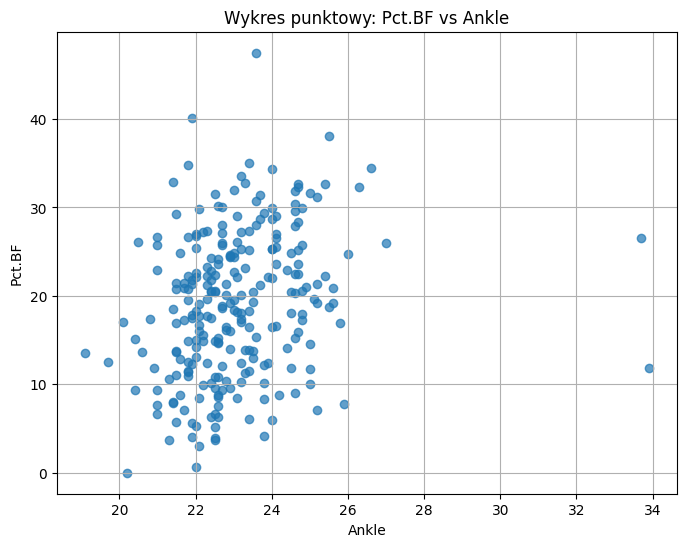

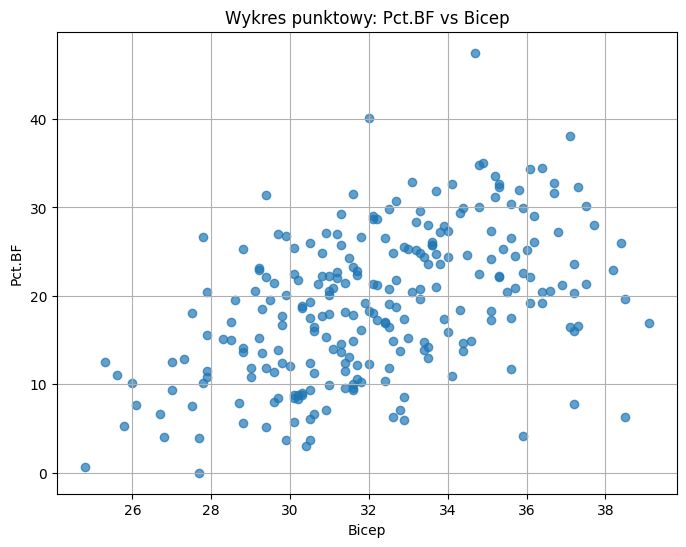

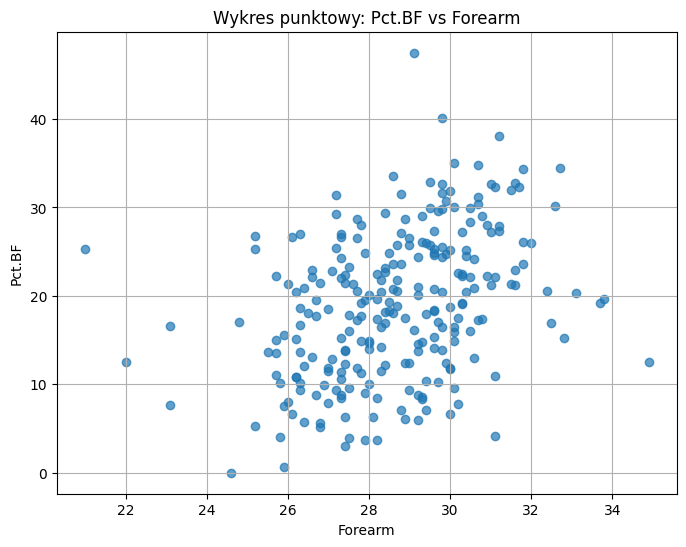

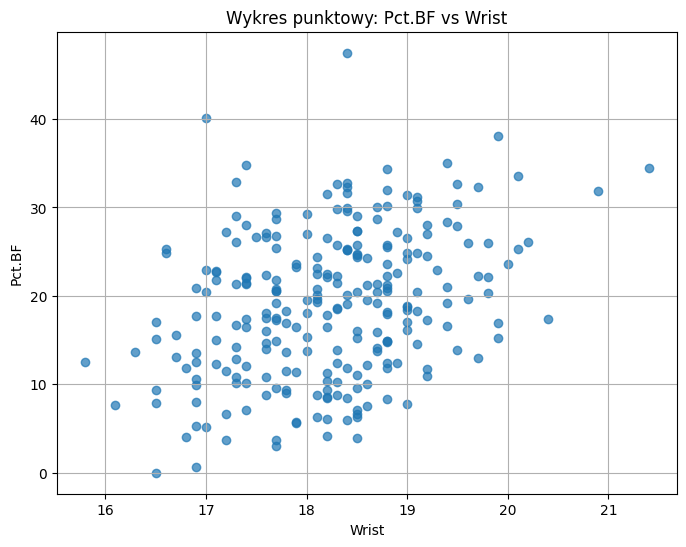

In [50]:
variables = data.columns.tolist()
#ariables.remove("Pct.BF")  # Usuwamy "Pct.BF", ponieważ jest zmienną zależną

# Tworzenie wykresów punktowych
for variable in variables:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[variable], data["Pct.BF"], alpha=0.7)
    plt.title(f"Wykres punktowy: Pct.BF vs {variable}")
    plt.xlabel(variable)
    plt.ylabel("Pct.BF")
    plt.grid(True)
    plt.show()  # Wyświetlenie każdego wykresu osobno

C:\Users\iskow\AppData\Local\Temp\ipykernel_50528\2765911252.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


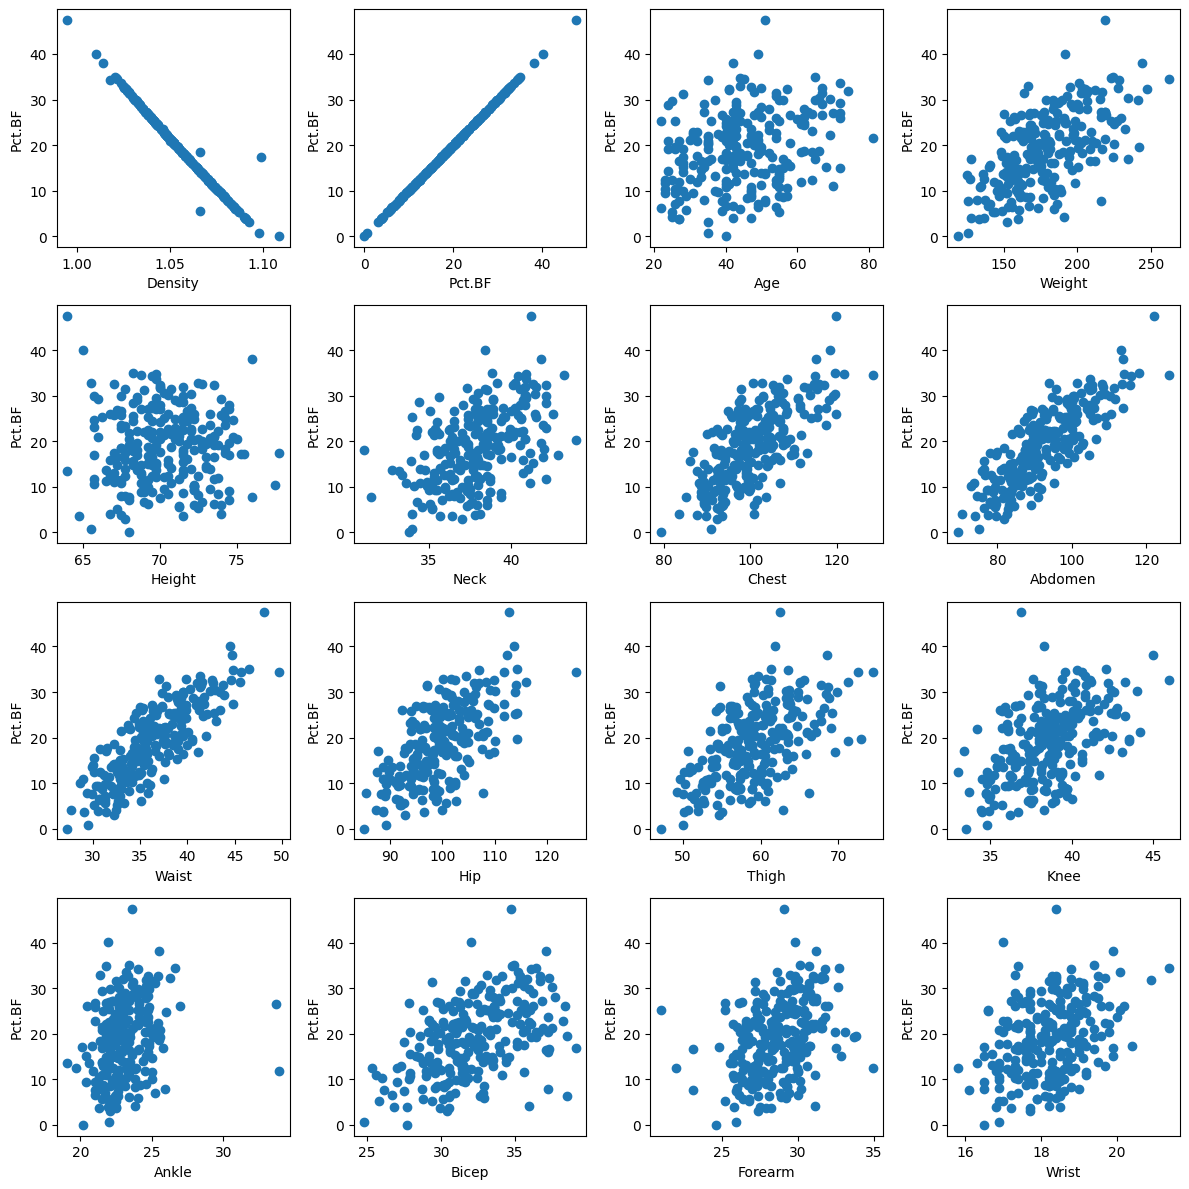

In [51]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
i = 0

for i, (name, X) in enumerate(data.items()):
    row = i // 4
    col = i % 4
    
    axs[row][col].scatter(X, data['Pct.BF'])
    axs[row][col].set_xlabel(name)
    axs[row][col].set_ylabel('Pct.BF')

fig.tight_layout()
fig.show()

In [52]:
# Obliczenie macierzy korelacji
correlation_matrix = data.corr()

# Wyświetlenie korelacji z "Pct.BF"
correlations_with_bodyfat = correlation_matrix["Pct.BF"].sort_values(ascending=False)
print("Korelacje ze zmienną 'Pct.BF':\n", correlations_with_bodyfat)


Korelacje ze zmienną 'Pct.BF':
 Pct.BF     1.000000
Waist      0.823685
Abdomen    0.823685
Chest      0.700670
Hip        0.632675
Weight     0.617299
Thigh      0.548550
Knee       0.492308
Neck       0.488524
Bicep      0.481538
Forearm    0.364709
Wrist      0.339008
Age        0.295051
Ankle      0.244556
Height    -0.029390
Density   -0.987480
Name: Pct.BF, dtype: float64


# model ze wszystkimi zmiennymi:

In [53]:
# Lista wszystkich zmiennych predykcyjnych (pomijając zmienną zależną "Pct.BF")
predictors = [col for col in data.columns if col != "Pct.BF"]

# Przygotowanie danych
X = sm.add_constant(data[predictors])  # Wszystkie zmienne predykcyjne + stała
y = data["Pct.BF"]  # Zmienna zależna

# Tworzenie pełnego modelu
model = sm.OLS(y, X).fit()

# Raport modelu regresji (wyniki statystyczne)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Pct.BF   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     683.1
Date:                Sun, 22 Dec 2024   Prob (F-statistic):          1.02e-183
Time:                        22:33:21   Log-Likelihood:                -407.87
No. Observations:                 250   AIC:                             847.7
Df Residuals:                     234   BIC:                             904.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        449.4921     11.556     38.898      0.0

# FORWARD SELECTION

In [54]:
#Forward selection na p-value
X = data.drop(columns=["Pct.BF"])
y = data["Pct.BF"]
def forward_selection_pvalue(X, y, significance_level=0.05, verbose=True):
   
    initial_list = []  # Lista wybranych zmiennych (na początku pusta)
    remaining_features = list(X.columns)  # Wszystkie dostępne zmienne
    step = 0
    best_model = None

    while len(remaining_features) > 0:
        p_values = pd.Series(index=remaining_features)
        for feature in remaining_features:
            temp_features = initial_list + [feature]
            model = sm.OLS(y, sm.add_constant(X[temp_features])).fit()
            p_values[feature] = model.pvalues[feature]

        min_p_value = p_values.min()
        best_feature = p_values.idxmin()

        if min_p_value < significance_level:
            step += 1
            initial_list.append(best_feature)
            remaining_features.remove(best_feature)
            best_model = sm.OLS(y, sm.add_constant(X[initial_list])).fit()
            if verbose:
                print(f"Krok {step}: Added {best_feature}, p-value = {min_p_value}")
        else:
            break

    return best_model


In [55]:
# Regresja krokowa w przód oparta na p-wartościach
# Standaryzacja predyktorów
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = sm.add_constant(X_scaled)  # Dodawanie stałej 

print("\nKroki regresji krokowej w przód na podstawie p-wartości:")
final_model_forward = forward_selection_pvalue(X_scaled, y)


print("\nFinal Model Coefficients (Forward Selection):")
print(final_model_forward.params)

print("\nPodsumowanie finalnego modelu:")
print(final_model_forward.summary())



Kroki regresji krokowej w przód na podstawie p-wartości:
Krok 1: Added Density, p-value = 6.324241050781242e-201
Krok 2: Added const, p-value = 7.438371107028322e-291
Krok 3: Added Abdomen, p-value = 1.930139489550953e-05

Final Model Coefficients (Forward Selection):
Density    -7.693554
const      19.031600
Abdomen     0.593555
dtype: float64

Podsumowanie finalnego modelu:
                            OLS Regression Results                            
Dep. Variable:                 Pct.BF   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     5221.
Date:                Sun, 22 Dec 2024   Prob (F-statistic):          8.34e-203
Time:                        22:33:21   Log-Likelihood:                -412.16
No. Observations:                 250   AIC:                             830.3
Df Residuals:                     247   BIC:                       

# LASSO

In [56]:
# Skalowanie danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selekcja zmiennych (jeśli jest już gotowa lista 'selected_features')
# Jeśli nie masz wybranych zmiennych, użyj wszystkich
selected_features = X.columns.tolist()
X_train_selected = X_train_scaled[:, [X.columns.get_loc(f) for f in selected_features]]
X_test_selected = X_test_scaled[:, [X.columns.get_loc(f) for f in selected_features]]

# LASSO z walidacją krzyżową (5-krotny podział)
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train_selected, y_train)
optimal_alpha = lasso_cv.alpha_
print('Optymalne alpha LASSO: ', optimal_alpha)
print("Współczynniki LASSO:")
print(pd.Series(lasso_cv.coef_, index=selected_features))

# Ocena na danych testowych
y_pred = lasso_cv.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Błąd MSE na danych testowych:", mse)
print("Współczynnik determinacji (R²):", r2)

Optymalne alpha LASSO:  0.14473234590379785
Współczynniki LASSO:
Density   -7.664553
Age        0.037150
Weight     0.000000
Height     0.000000
Neck       0.000000
Chest      0.087954
Abdomen    0.494177
Waist      0.000000
Hip        0.000000
Thigh      0.000000
Knee       0.000000
Ankle     -0.000000
Bicep      0.000000
Forearm    0.000000
Wrist      0.000000
dtype: float64
Błąd MSE na danych testowych: 1.7608670290753423
Współczynnik determinacji (R²): 0.9705281672733422


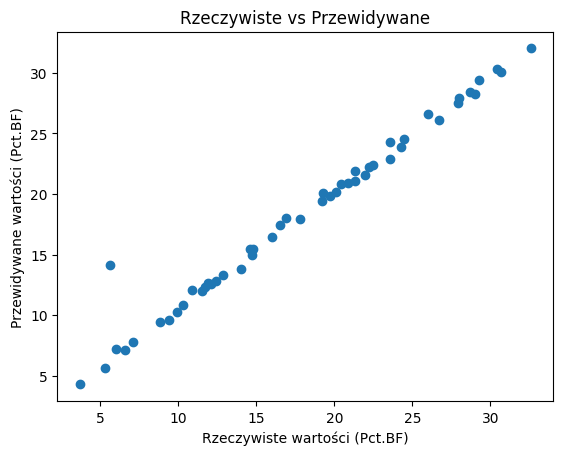

In [57]:
plt.scatter(y_test, y_pred)
plt.xlabel("Rzeczywiste wartości (Pct.BF)")
plt.ylabel("Przewidywane wartości (Pct.BF)")
plt.title("Rzeczywiste vs Przewidywane")
plt.show()

# Backward SELECTION na p-value

In [58]:
def backward_selection_pvalue(X, y, significance_level=0.05, verbose=True):
    
    initial_list = X.columns.tolist()
    step = 0
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1:]  # Pomijamy stałą 
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            step += 1
            worst_feature = p_values.idxmax()
            if verbose:
                print(f"Krok {step}: Removed {worst_feature}, p-value = {max_p_value}")
            X = X.drop(columns=[worst_feature])
        else:
            break
    
    return model


In [59]:
# Standaryzacja predyktorów
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = sm.add_constant(X_scaled)  # Dodawanie stałą (intercept)

# Regresja wsteczna oparta na p-wartościach
print("\nKroki regresji wstecznej na podstawie p-wartości:")
final_model = backward_selection_pvalue(X_scaled, y)

print("\nFinal Model Coefficients:")
print(final_model.params)


print("\nPodsumowanie finalnego modelu:")
print(final_model.summary())



Kroki regresji wstecznej na podstawie p-wartości:
Krok 1: Removed Wrist, p-value = 0.89304819534277
Krok 2: Removed Forearm, p-value = 0.877994426961312
Krok 3: Removed Height, p-value = 0.8066146650331913
Krok 4: Removed Neck, p-value = 0.7960856128324365
Krok 5: Removed Knee, p-value = 0.7796126317977481
Krok 6: Removed Waist, p-value = 0.646801839461697
Krok 7: Removed Thigh, p-value = 0.5993862960507086
Krok 8: Removed Hip, p-value = 0.6177412707234711
Krok 9: Removed Chest, p-value = 0.4150693354884293
Krok 10: Removed Bicep, p-value = 0.24868589736583693
Krok 11: Removed Weight, p-value = 0.2684098056044601
Krok 12: Removed Ankle, p-value = 0.32780368858280173
Krok 13: Removed Age, p-value = 0.07373728693671264

Final Model Coefficients:
const      19.031600
Density    -7.693554
Abdomen     0.593555
dtype: float64

Podsumowanie finalnego modelu:
                            OLS Regression Results                            
Dep. Variable:                 Pct.BF   R-squared:      

# Nowy model - predykcja wagi

In [60]:
X = data.drop(columns=["Weight"])
y = data["Weight"]

#Backward Rgression:
def backward_selection_weight(X, y, significance_level=0.05, verbose=True):
    initial_list = X.columns.tolist()
    step = 0
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1:]  # Pomijamy stałą
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            step += 1
            worst_feature = p_values.idxmax()
            if verbose:
                print(f"Krok {step}: Removed {worst_feature}, p-value = {max_p_value}")
            X = X.drop(columns=[worst_feature])
        else:
            break
    
    return model


In [61]:
# Standaryzacja predyktorów
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = sm.add_constant(X_scaled)  # Dodawanie stałą (intercept)

# Regresja wsteczna oparta na p-wartościach
print("\nKroki regresji wstecznej na podstawie p-wartości:")
final_model = backward_selection_pvalue(X_scaled, y)

print("\nFinal Model Coefficients:")
print(final_model.params)


print("\nPodsumowanie finalnego modelu:")
print(final_model.summary())


Kroki regresji wstecznej na podstawie p-wartości:
Krok 1: Removed Waist, p-value = 0.641490678473595
Krok 2: Removed Pct.BF, p-value = 0.4493392230553245
Krok 3: Removed Density, p-value = 0.6081240082851028
Krok 4: Removed Forearm, p-value = 0.06032344172605572

Final Model Coefficients:
const      178.083200
Age         -1.341067
Height       5.125855
Neck         2.204049
Chest        7.316002
Abdomen      4.983897
Hip          5.828459
Thigh        1.999567
Knee         1.166520
Ankle        0.980171
Bicep        1.741805
Wrist        1.386553
dtype: float64

Podsumowanie finalnego modelu:
                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     944.0
Date:                Sun, 22 Dec 2024   Prob (F-statistic):          2.08e-189
Tim

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Funkcja do obliczania VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Obliczanie VIF dla końcowych zmiennych w modelu
X_final = X_scaled.drop(columns=["const", "Density", "Pct.BF", "Waist", "Forearm"])  # Usuń kolumnę stałej
vif_results = calculate_vif(X_final)
print(vif_results)


    Feature        VIF
0       Age   2.135006
1    Height   1.790126
2      Neck   3.594354
3     Chest   7.430969
4   Abdomen  10.310752
5       Hip  10.032213
6     Thigh   6.898506
7      Knee   4.345676
8     Ankle   1.751022
9     Bicep   2.958478
10    Wrist   3.091087


In [63]:
# Dodaj stałą do danych
X_final2 = sm.add_constant(X_final.drop(columns=["Hip"]))

# Dopasowanie modelu OLS
model_final = sm.OLS(y, X_final2).fit()
print(model_final.summary())

# Usuń "const" tylko dla obliczeń VIF
X_vif = X_final2.drop(columns=["const"])

# Obliczenie VIF
vif_results_final = calculate_vif(X_vif)
print("\nFinal VIF values:")
print(vif_results_final)



                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     859.4
Date:                Sun, 22 Dec 2024   Prob (F-statistic):          3.79e-181
Time:                        22:33:22   Log-Likelihood:                -727.30
No. Observations:                 250   AIC:                             1477.
Df Residuals:                     239   BIC:                             1515.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        178.0832      0.287    620.302      0.0

# OD CZEGO ZALEŻY DENSITY?

In [64]:
X = data.drop(columns=["Density", "Pct.BF"])
y = data["Density"]


#Backward Rgression:
def backward_selection_weight(X, y, significance_level=0.05, verbose=True):
    initial_list = X.columns.tolist()
    step = 0
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1:]  # Pomijamy stałą
        max_p_value = p_values.max()

        if max_p_value > significance_level:
            step += 1
            worst_feature = p_values.idxmax()
            if verbose:
                print(f"Krok {step}: Removed {worst_feature}, p-value = {max_p_value}")
            X = X.drop(columns=[worst_feature])
        else:
            break

    return model


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = sm.add_constant(X_scaled)  # Dodawanie stałej

print("\nKroki regresji wstecznej na podstawie p-wartości:")
final_model = backward_selection_pvalue(X_scaled, y)

print("\nFinal Model Coefficients:")
print(final_model.params)

print("\nPodsumowanie finalnego modelu:")
print(final_model.summary())


Kroki regresji wstecznej na podstawie p-wartości:
Krok 1: Removed Knee, p-value = 0.9177098355504427
Krok 2: Removed Abdomen, p-value = 0.7583188947095197
Krok 3: Removed Weight, p-value = 0.5930065058068587
Krok 4: Removed Ankle, p-value = 0.23592022178933383
Krok 5: Removed Forearm, p-value = 0.1962286313340589
Krok 6: Removed Thigh, p-value = 0.15127843986128398
Krok 7: Removed Hip, p-value = 0.2830978988356266
Krok 8: Removed Neck, p-value = 0.1329284313702869
Krok 9: Removed Bicep, p-value = 0.055916485509923626
Krok 10: Removed Age, p-value = 0.10168286576726104

Final Model Coefficients:
const     1.055838
Height    0.002626
Chest     0.003463
Waist    -0.020878
Wrist     0.003315
dtype: float64

Podsumowanie finalnego modelu:
                            OLS Regression Results                            
Dep. Variable:                Density   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.717
Method:           

In [65]:
X_final = X_scaled[["Height", "Chest", "Waist", "Wrist"]]

# Obliczanie VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]

print(vif_data)

  Variable       VIF
0   Height  1.194223
1    Chest  6.366219
2    Waist  5.858792
3    Wrist  1.941994


In [66]:
X_final_reduced = X_final.drop(columns=["Chest"])

# Obliczanie VIF po usunięciu zmiennej
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Variable"] = X_final_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_final_reduced.values, i) for i in range(X_final_reduced.shape[1])]

print(vif_data_reduced)


  Variable       VIF
0   Height  1.193189
1    Waist  1.577430
2    Wrist  1.807272


In [67]:
# Dopasowanie modelu po usunięciu zmiennej
model_reduced = sm.OLS(y, sm.add_constant(X_final_reduced)).fit()

print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                Density   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     207.2
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           4.98e-67
Time:                        22:33:22   Log-Likelihood:                 795.80
No. Observations:                 250   AIC:                            -1584.
Df Residuals:                     246   BIC:                            -1570.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0558      0.001   1651.020      0.0